# Group Details

## Group Name: GLF

### Student 1: Fabio D'Agostino

### Student 2: Levente Zolyomi

### Student 3: Gabriel Ziegler

# Loading Data and Preliminaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


# Task 1

In [ ]:
#### Create adjacency matrix

# Define distance metrics
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y)**2))

def inverse_distance(x, y):
    return 1 / euclidean_distance(x, y)

# Create adjacency matrix function
def create_adjacency_matrix(data, distance_metric):
    n = data.shape[0]
    adjacency_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:  # we don't calculate the distance of the object to itself
                # we extract the position [x, y] for both objects i and j
                position_i = data[i, 1:3]
                position_j = data[j, 1:3]
                adjacency_matrix[i, j] = distance_metric(position_i, position_j)
    return adjacency_matrix

# Validate input
def validate_input(X, adjacency_matrix):
    # X should be a 2D tensor
    assert X.dim() == 2, f"X must be 2D, but got shape {X.shape}"

    # The number of nodes should be the same in X and the adjacency matrix
    assert X.shape[0] == adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Mismatch in number of nodes: got {X.shape[0]} nodes in X, but {adjacency_matrix.shape[0]} nodes in adjacency matrix"

    # The adjacency matrix should be square
    assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Adjacency matrix must be square, but got shape {adjacency_matrix.shape}"

    print("All checks passed.")


In [ ]:
# Load and examine sample data
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state(X): shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state(y): shape (n_bodies, [x, y])

"""


X, y= load_array('data/task 1/train/trajectory_0.npz', task='task 1')
X = torch.tensor(X, dtype=torch.float32)


In [ ]:
# Final model
from torch_geometric.nn import SAGEConv

class MinGraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(MinGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)

        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Droput
        x = self.dropout(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x




In [ ]:
# DataLoader

from torch_geometric.data import Dataset, Data, DataLoader

class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 1')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)

        return data

filenames = [f'data/task 1/train/trajectory_{i}.npz' for i in range(900)]

split_point = 720 # take 20% of the data for validation

# Create two subsets for train/validation split from the filenames list
train_filenames = filenames[:split_point]
val_filenames = filenames[split_point:]

train_dataset = MyDataset(root='data/task 1/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=32)

# Create validation dataset from val_filenames
val_dataset = MyDataset(root='data/task 1/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prepare for validation data set

test_filenames = [f'data/task 1/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 1/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=32)

/home/gabrielziegler/PyEnv/DeepLearning/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Training Loss: 7.653035640716553, Val Loss: 6.99659472571479
Epoch: 2, Training Loss: 6.771702289581299, Val Loss: 6.157435894012451
Epoch: 3, Training Loss: 6.60842227935791, Val Loss: 5.924193912082249
Epoch: 4, Training Loss: 6.422076225280762, Val Loss: 5.784953382280138
Epoch: 5, Training Loss: 6.393649101257324, Val Loss: 5.679038111368815
Epoch: 6, Training Loss: 6.403233528137207, Val Loss: 5.627186754014757
Epoch: 7, Training Loss: 6.022755146026611, Val Loss: 5.563667445712619
Epoch: 8, Training Loss: 5.756962299346924, Val Loss: 5.468245548672146
Epoch: 9, Training Loss: 5.603871822357178, Val Loss: 5.402890671624077
Epoch: 10, Training Loss: 5.550587177276611, Val Loss: 5.376962089538575
Epoch: 11, Training Loss: 5.650533676147461, Val Loss: 5.3032515631781685
Epoch: 12, Training Loss: 5.709211826324463, Val Loss: 5.258898872799343
Epoch: 13, Training Loss: 5.71054744720459, Val Loss: 5.231115383572049
Epoch: 14, Training Loss: 5.145211219787598, Val Loss: 5.24033

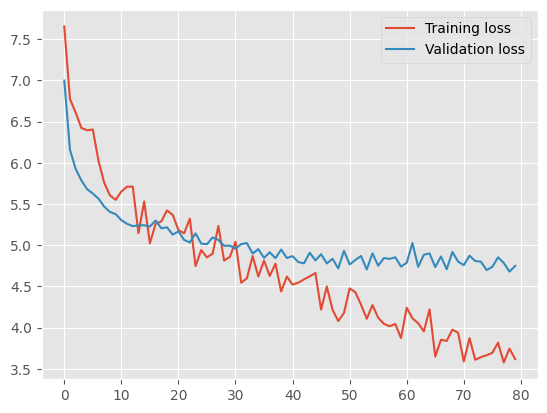

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu
model = MinGraphSAGE(num_features=5, hidden_channels=64, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

# Store losses
train_losses = []
val_losses = []

epochs = 80

for epoch in range(epochs):  
    # Training
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass
        loss = criterion(out, batch.y)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters
    train_losses.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out, batch.y).item() * batch.num_graphs
        
    val_loss /= len(val_dataset)  # compute average validation loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Val Loss: {val_loss}')


# Plot losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# Calculate MSE loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        out = model(batch)
        test_loss += criterion(out, batch.y).item() * batch.num_graphs
    
test_loss /= len(test_dataset)  # compute average validation loss
print(f'Test Loss for task 1: {test_loss}')

Test Loss for task 1: 3.448903105475686


In [ ]:
# Calculate static and linear baselines (formula on ANS)
def static_baseline(X):
    return X[:, 1:3]  # initial x,y coordinates

def linear_baseline(X):
    return X[:, 1:3] + X[:, 3:5] * 5  # initial x,y coordinates plus velocity times time

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        total_loss += criterion(predictions, batch.y).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, train_dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, train_dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

test_loss_static = compute_baseline_loss(static_baseline, test_dataloader)
test_loss_linear = compute_baseline_loss(linear_baseline, test_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')
print(f'Test Loss - Static Baseline: {test_loss_static:0.4f}, Linear Baseline: {test_loss_linear:0.4f}')


Training Loss   - Static Baseline: 14.0342, Linear Baseline: 21.9515
Validation Loss - Static Baseline: 13.5344, Linear Baseline: 23.0688
Test Loss - Static Baseline: 11.4824, Linear Baseline: 20.2710


# Experiments

Take the 10 trajectories with highest and lowest loss to analyse.

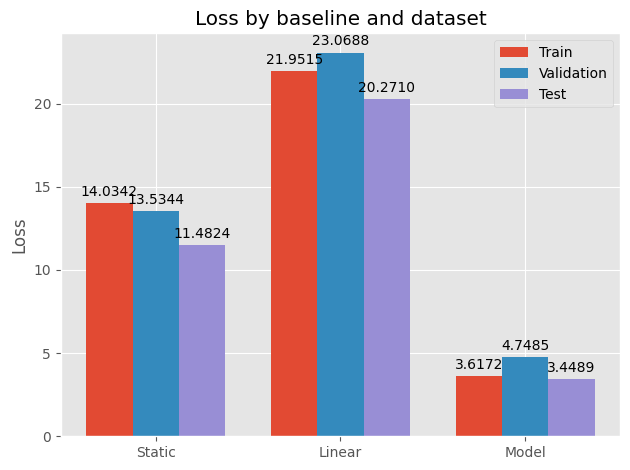

In [ ]:
# Create barplot with static and linear baseline losses for train-test-val 3 separate bars

import matplotlib.pyplot as plt
import numpy as np

train_losses = [train_loss_static, train_loss_linear, loss.item()]
val_losses = [val_loss_static, val_loss_linear, val_loss]
test_losses = [test_loss_static, test_loss_linear, test_loss]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by baseline and dataset')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear', "Model"])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

/home/gabrielziegler/PyEnv/DeepLearning/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


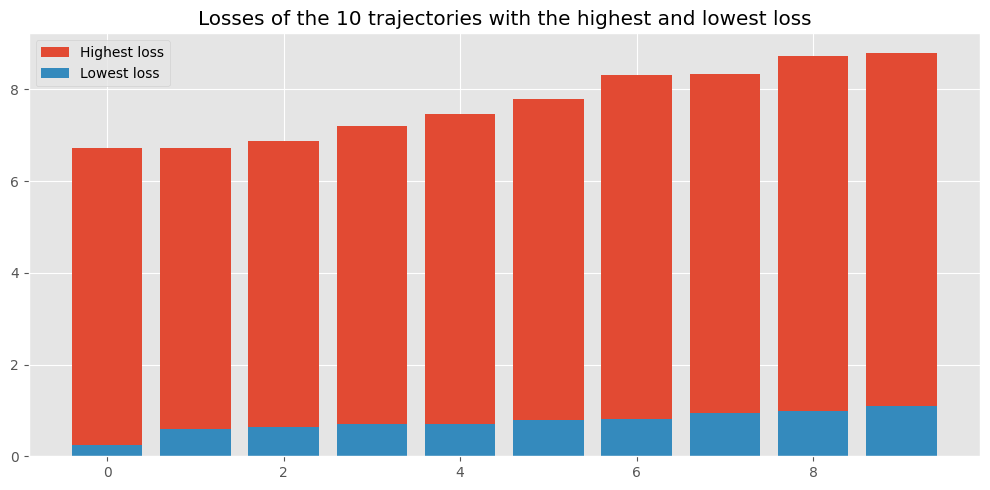

In [ ]:
# 6a experiment: grab 10 trajectories from the experiment set that were correctly predicted and 10 that were incorrectly predicted to analyse them

experiment_dataloader = DataLoader(test_dataset, batch_size=1)

experiment_losses = []
experiment_predictions = []
experiment_labels = []

model.eval()
with torch.no_grad():
    for batch in experiment_dataloader:
        batch = batch.cpu()
        out = model.cpu()(batch)
        loss = criterion(out, batch.y)
        experiment_losses.append(loss.item())
        experiment_predictions.append(out)
        experiment_labels.append(batch.y)

# Get the indices of the 10 trajectories with the highest loss
highest_loss_indices = np.argsort(experiment_losses)[-10:]

# Get the indices of the 10 trajectories with the lowest loss
lowest_loss_indices = np.argsort(experiment_losses)[:10]

# np.array(experiment_losses)[highest_loss_indices]
# plot 10 bars with the losses of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss with the same y-axis
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), np.array(experiment_losses)[highest_loss_indices], label='Highest loss')
plt.bar(np.arange(10), np.array(experiment_losses)[lowest_loss_indices], label='Lowest loss')
plt.title('Losses of the 10 trajectories with the highest and lowest loss')
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
def plot_trajectories(indices, title=""):
    trajectories = test_dataset[indices]

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    axes[0].set_xlim(-10, 10)
    axes[0].set_ylim(-10, 10)

    # iterate over projections
    for i in range(len(trajectories)):
        # Get the initial position
        initial_position_x = trajectories.x[i][1]
        initial_position_y = trajectories.x[i][2]

        # Get the final position
        final_position_x = trajectories.y[i][0]
        final_position_y = trajectories.y[i][1]

        axes[i].scatter(initial_position_x, initial_position_y, label='Initial position', marker='o', s=100)
        axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)

        # Get the predicted position
        predicted_position_x = experiment_predictions[indices][i][0]
        predicted_position_y = experiment_predictions[indices][i][1]

        axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

        # Draw dashed line from initial position to predicted position
        axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

        # Get the label
        label = experiment_labels[indices]

        # Draw dashed line from initial position to label
        axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

        axes[i].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


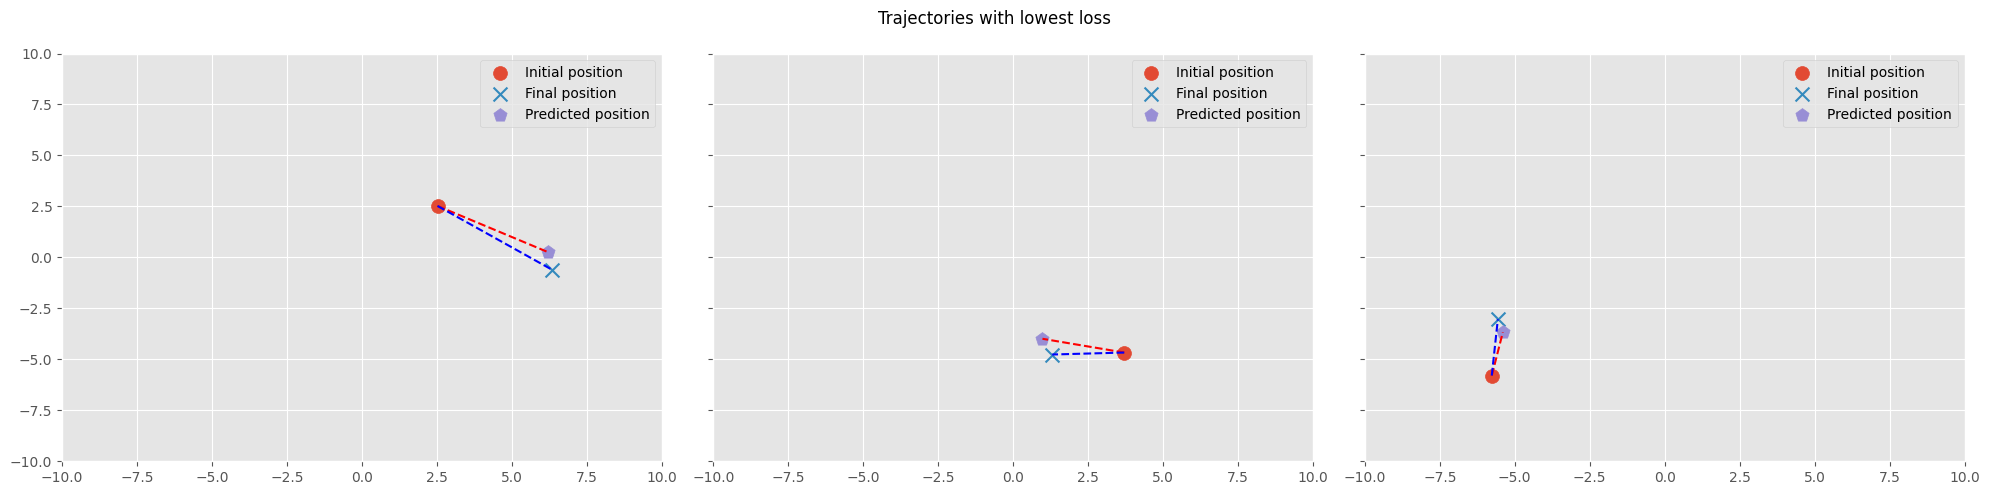

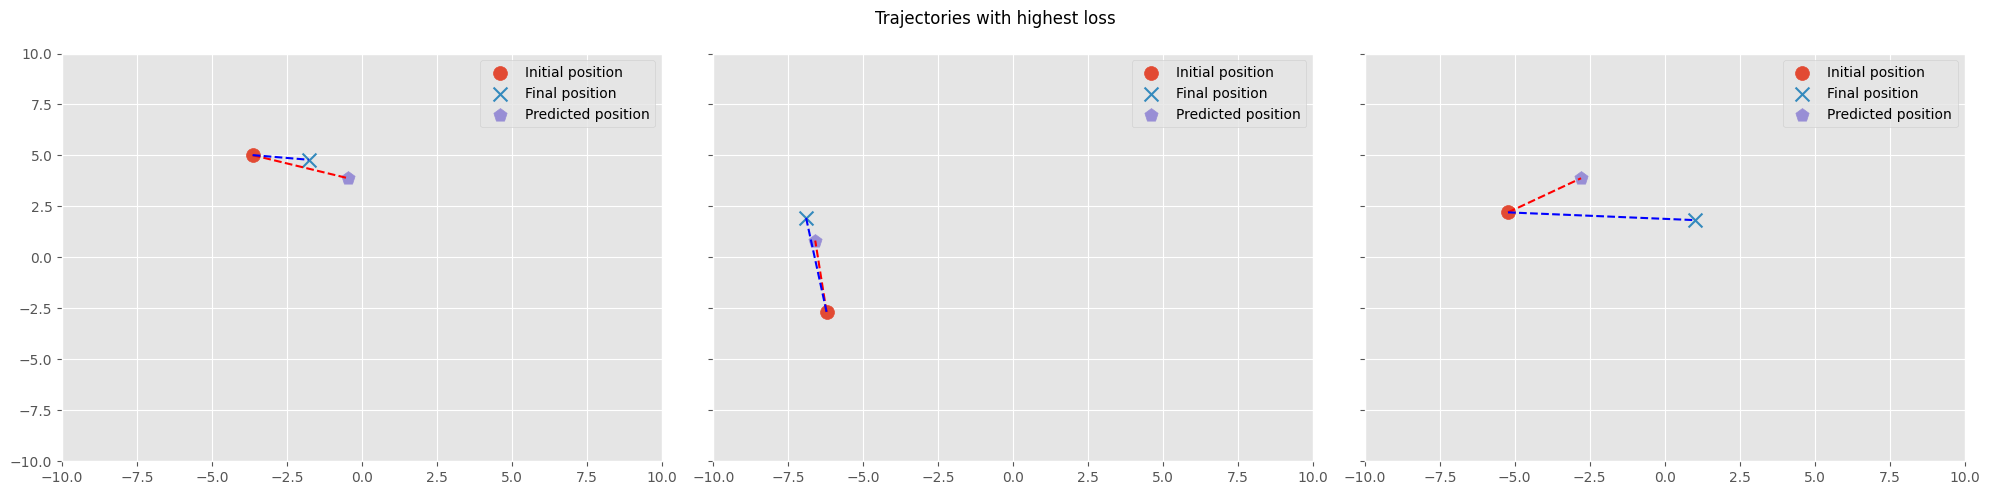

In [ ]:
plot_trajectories(lowest_loss_indices[0], title="Trajectories with lowest loss")
plot_trajectories(highest_loss_indices[-1], title="Trajectories with highest loss")

In [ ]:
import seaborn as sns
from scipy import stats

def plot_boxplot(var):
    var_map = {
        'mass': 0,
        'pos_x': 1,
        'pos_y': 2,
        'vel_x': 3,
        'vel_y': 4,
    }
    # plot boxplot of the mean of the masses of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 5))

    axes[0].boxplot([torch.mean(test_dataset[lowest_loss_indices[i]].x[:, var_map[var]]) for i in range(len(lowest_loss_indices))])
    axes[0].set_title(f'Mean of the {var} of the 10 trajectories with the lowest loss')

    axes[1].boxplot([torch.mean(test_dataset[highest_loss_indices[i]].x[:, var_map[var]]) for i in range(len(highest_loss_indices))])
    axes[1].set_title(f'Mean of the {var} of the 10 trajectories with the highest loss')

    # Run an ANOVA test to see if there is a significant difference between the means of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss
    print(f'ANOVA test for {var}:')
    print(stats.f_oneway([torch.mean(test_dataset[lowest_loss_indices[i]].x[:, var_map[var]]) for i in range(len(lowest_loss_indices))], [torch.mean(test_dataset[highest_loss_indices[i]].x[:, var_map[var]]) for i in range(len(highest_loss_indices))]))

    plt.tight_layout()
    plt.show()

ANOVA test for mass:
F_onewayResult(statistic=1.6892878453437428, pvalue=0.21009433422700488)


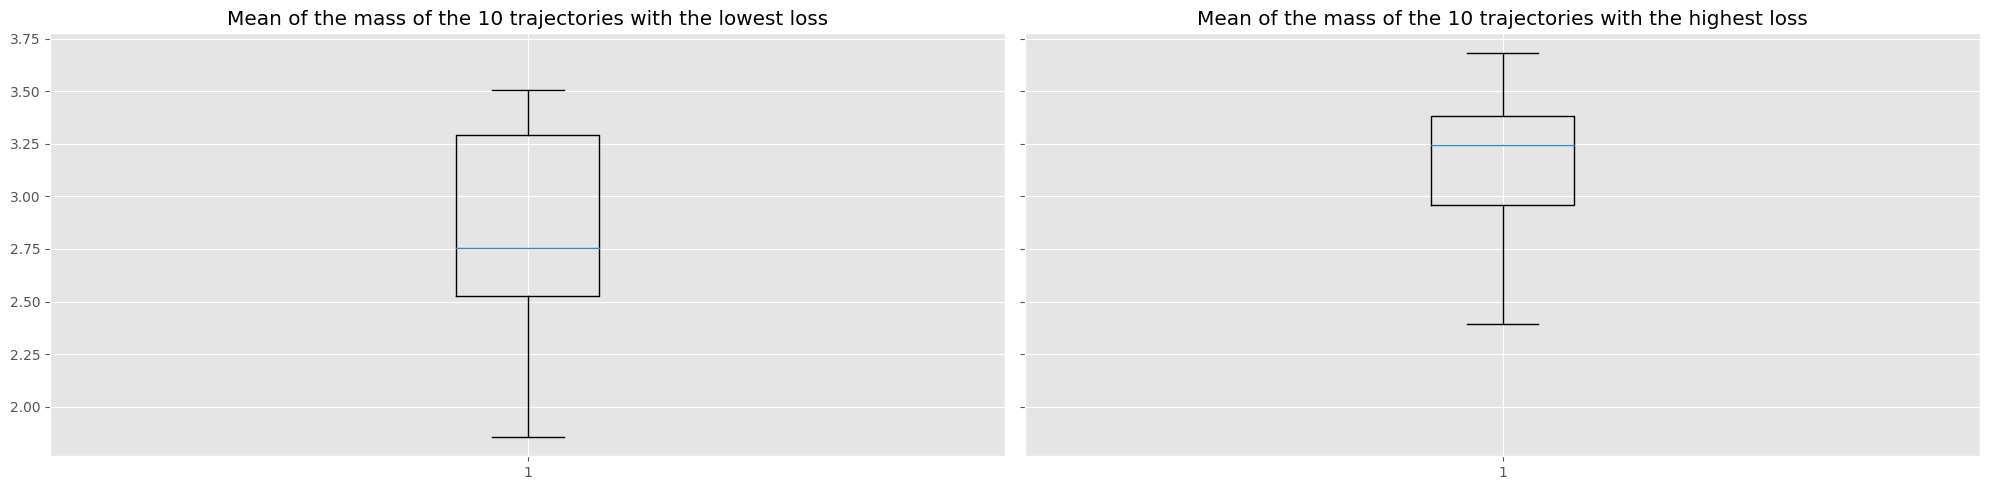

ANOVA test for vel_x:
F_onewayResult(statistic=0.11517470317791004, pvalue=0.7382554992246061)


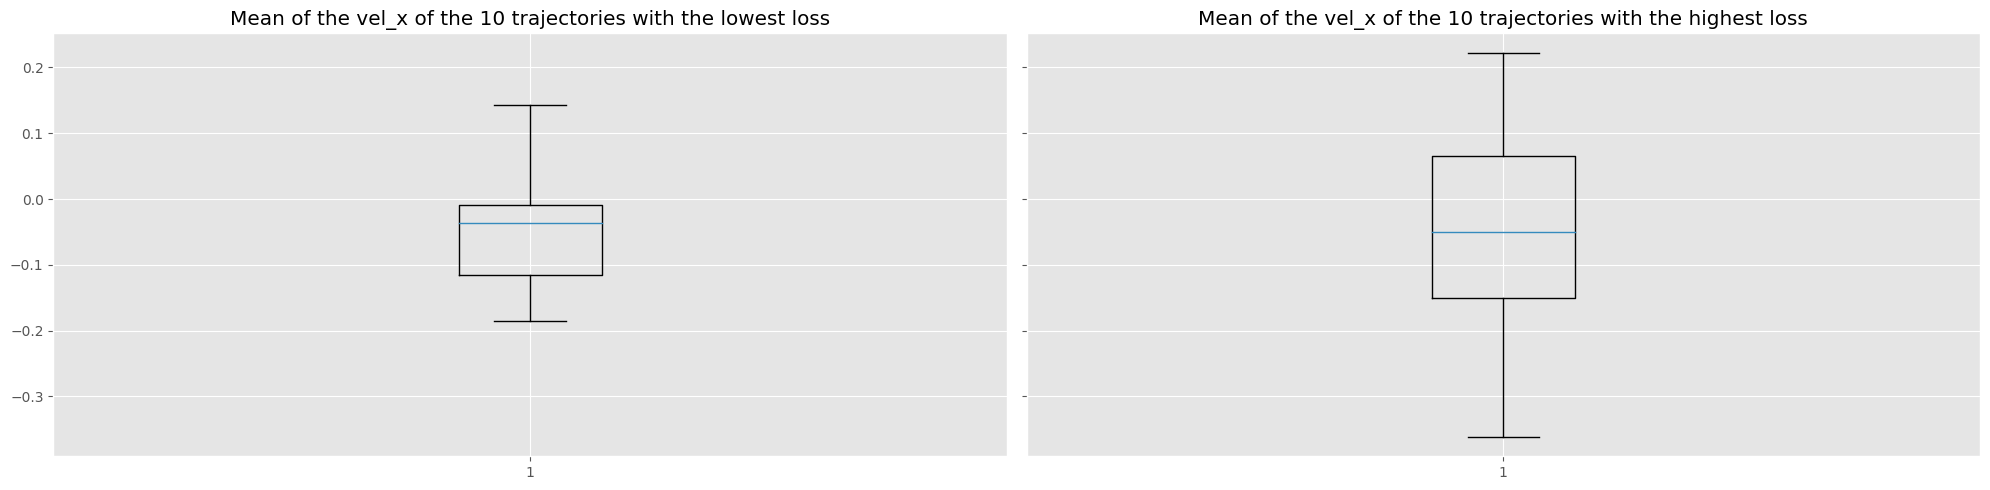

ANOVA test for vel_y:
F_onewayResult(statistic=0.36825498028236225, pvalue=0.5515352631118935)


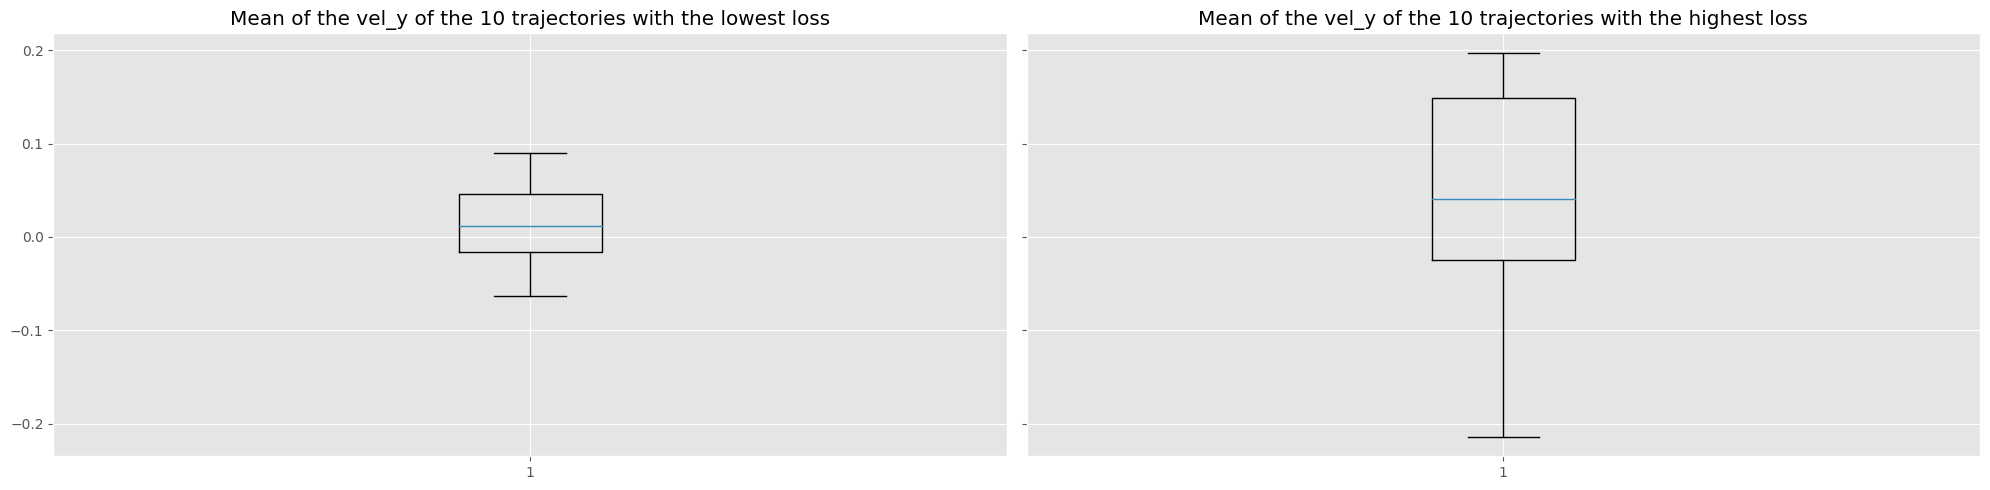

ANOVA test for pos_x:
F_onewayResult(statistic=0.14631257808452977, pvalue=0.7065634581134648)


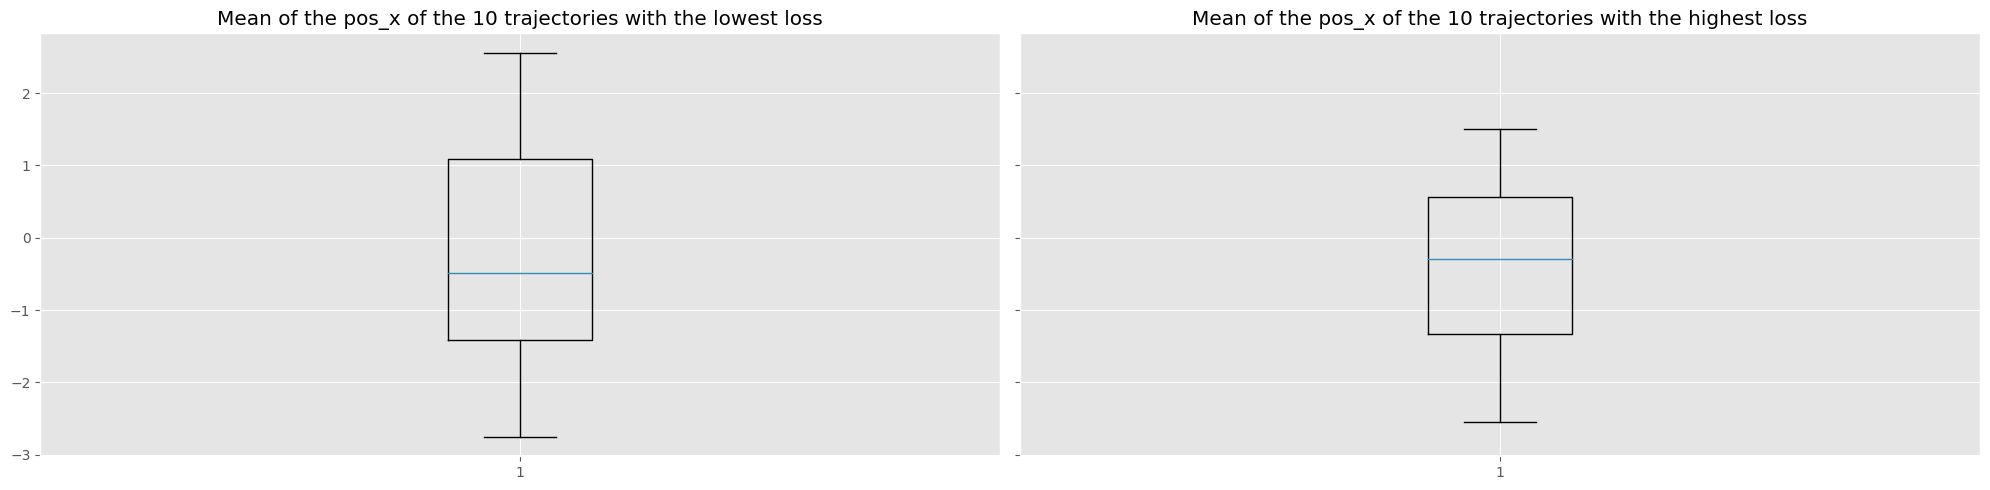

ANOVA test for pos_y:
F_onewayResult(statistic=0.12501916951429062, pvalue=0.7277607797518453)


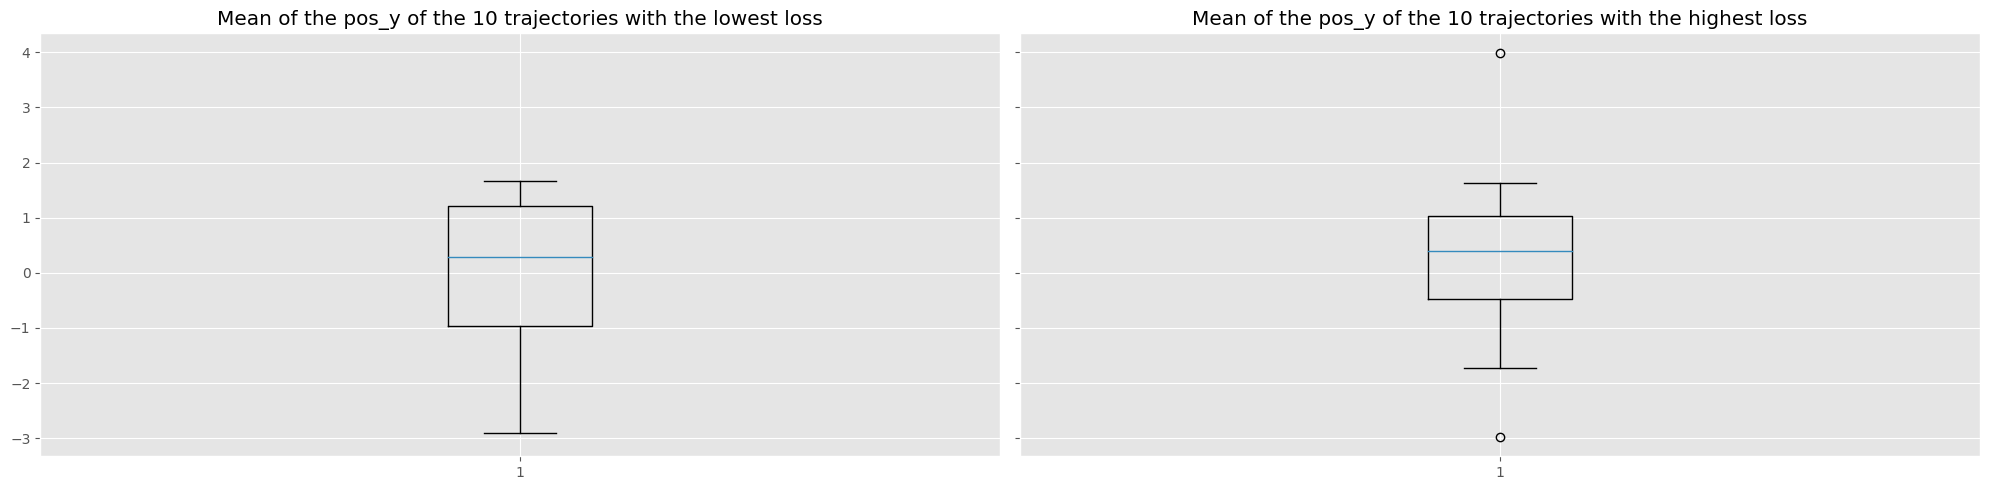

In [ ]:
plot_boxplot('mass')
plot_boxplot('vel_x')
plot_boxplot('vel_y')
plot_boxplot('pos_x')
plot_boxplot('pos_y')

# Task 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data

In [ ]:
# Check datashape
X, y= load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

In [ ]:
# Model for TASK 2

from torch_geometric.nn import SAGEConv
import torch.nn as nn

class GraphLSTM(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphLSTM, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)

        # add a sequential 2 fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
 
        # mu, log_var 

        # LSTM layer
        # Repeat x along a new temporal dimension to create a sequence, with the repeated
        # x as the input at each time step. This is necessary because the LSTM expects
        # input of the form (batch_size, sequence_length, input_size).
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)

        # Pass the sequence of node states through the LSTM.
        # Note that we discard the LSTM's hidden state output, as we are only
        # interested in its output sequences for this application.
        x, _ = self.lstm(x)

        #  Pass it through the fully connected layers
        x = self.fc(x)

        return x


In [ ]:
# DataLoaders for task 2
class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 2')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)   # y is now a 3D tensor

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)  # y is now a 3D tensor

        return data

filenames = [f'data/task 2_3/train/trajectory_{i}.npz' for i in range(900)]
split_point=720
# Do training validation split
train_filenames = filenames[:split_point]
val_filenames = filenames[split_point:]

train_dataset = MyDataset(root='data/task 2_3/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=32)

val_dataset = MyDataset(root='data/task 2_3/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prepare for validation data set

test_filenames = [f'data/task 2_3/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 2_3/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=32)

c:\Users\dagos\miniconda3\envs\mlcourse\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Calculate baseline losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def static_baseline(X):
    initial_position = X[:, 1:3]  # initial x,y coordinates
    # Repeat the initial position for each timestep
    return initial_position.unsqueeze(1).repeat(1, 49, 1)  # assuming 49 timesteps

def linear_baseline(X):
    initial_position = X[:, 1:3]  # initial x,y coordinates
    initial_velocity = X[:, 3:5]  # initial velocity
    # Predict position for each timestep using v = u + at
    return initial_position.unsqueeze(1) + initial_velocity.unsqueeze(1) * (torch.arange(49).to(X.device).reshape(1, -1, 1) / 10)  

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        # Only take the position labels for loss calculation
        pos_labels = batch.y[..., :2]
        total_loss += criterion(predictions, pos_labels).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, train_dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, train_dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

test_loss_static = compute_baseline_loss(static_baseline, test_dataloader)
test_loss_linear = compute_baseline_loss(linear_baseline, test_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')
print(f'Test Loss - Static Baseline: {test_loss_static:0.4f}, Linear Baseline: {test_loss_linear:0.4f}')


Training Loss   - Static Baseline: 5.1366, Linear Baseline: 6.1834
Validation Loss - Static Baseline: 4.7699, Linear Baseline: 6.6162
Test Loss - Static Baseline: 5.1950, Linear Baseline: 6.5654


Epoch: 1, Training Loss: 3.149125099182129, Val Loss: 4.059797181023492
Epoch: 2, Training Loss: 3.5347588062286377, Val Loss: 3.5736360443962947
Epoch: 3, Training Loss: 2.8996121883392334, Val Loss: 3.3842511388990615
Epoch: 4, Training Loss: 2.7999930381774902, Val Loss: 3.203597052892049
Epoch: 5, Training Loss: 2.627436399459839, Val Loss: 2.970751264360216
Epoch: 6, Training Loss: 2.541625738143921, Val Loss: 2.920487536324395
Epoch: 7, Training Loss: 2.4525036811828613, Val Loss: 2.899170462290446
Epoch: 8, Training Loss: 2.433115005493164, Val Loss: 2.8024553775787355
Epoch: 9, Training Loss: 2.3357646465301514, Val Loss: 2.7075766775343153
Epoch: 10, Training Loss: 2.253978729248047, Val Loss: 2.672002262539334
Epoch: 11, Training Loss: 2.1549441814422607, Val Loss: 2.70019039577908
Epoch: 12, Training Loss: 2.0473320484161377, Val Loss: 2.631707451078627
Epoch: 13, Training Loss: 2.032727003097534, Val Loss: 2.499221348762512
Epoch: 14, Training Loss: 1.9232221841812134, Val 

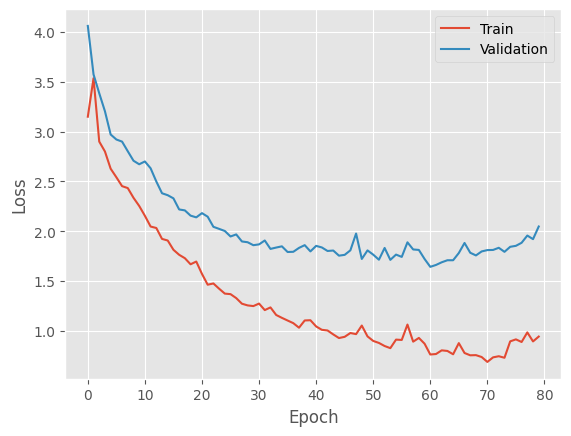

In [ ]:
# Training the model
model = GraphLSTM(num_features=5, hidden_channels=64, num_classes=4, num_time_steps=49).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

# Train and validation losses
train_losses = []
val_losses = []

epochs = 80

for epoch in range(epochs):  
    # Training
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass

        # Only take the position predictions (first two dimensions of the last dimension) for loss calculation
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]

        loss = criterion(pos_out, pos_labels)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters
    train_losses.append(loss.item())


    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            pos_out = out[..., :2]
            pos_labels = batch.y[..., :2]
            val_loss += criterion(pos_out, pos_labels).item() * batch.num_graphs
    

    val_loss /= len(val_dataset)  # compute average validation loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Val Loss: {val_loss}')
import matplotlib.pyplot as plt
# Plot train and validation losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Measure performance of model on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        out = model(batch)
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]
        test_loss += criterion(pos_out, pos_labels).item() * batch.num_graphs

test_loss /= len(test_dataset)  # compute average test loss
print(f'Test Loss for task 2: {test_loss}')

Test Loss for task 2: 2.2168907902457495


# Experiments

Take the 10 trajectories with highest and lowest loss to analyse.

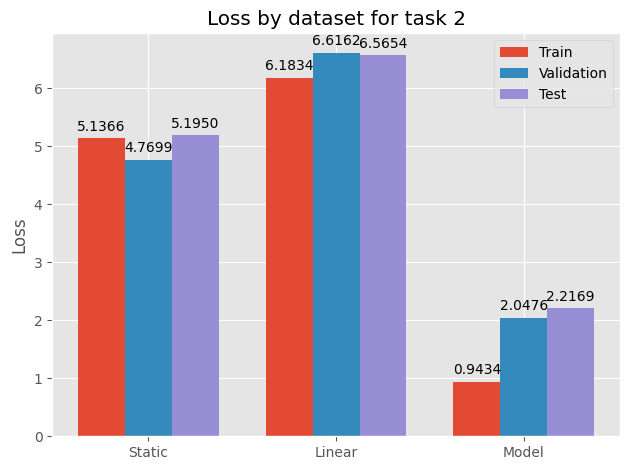

In [ ]:

#Question 10c
# Plot the losses

import matplotlib.pyplot as plt
import numpy as np

train_losses = [train_loss_static, train_loss_linear, loss.item()]
val_losses = [val_loss_static, val_loss_linear, val_loss]
test_losses = [test_loss_static, test_loss_linear, test_loss]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by dataset for task 2')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear', "Model"])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

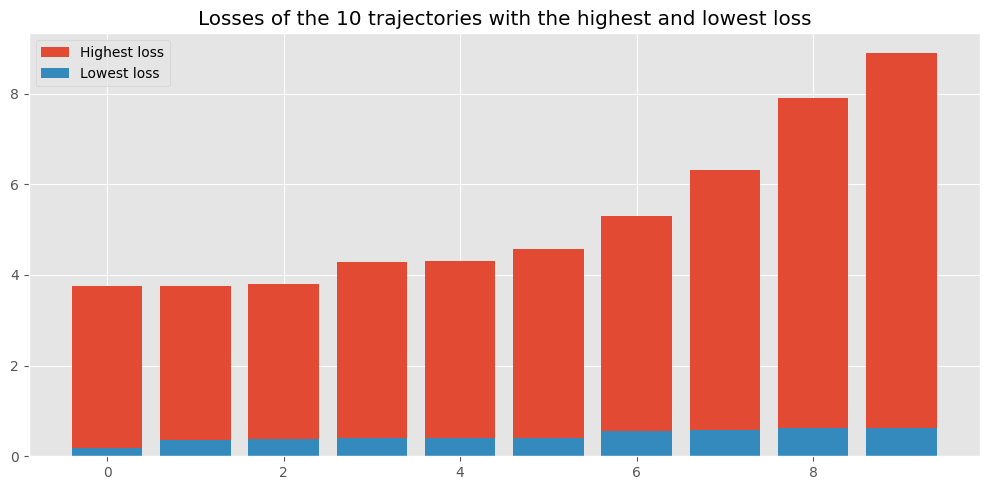

In [ ]:
# 10a experiment: grab 10 trajectories from the experiment set that were correctly predicted and 10 that were incorrectly predicted to analyse them

experiment_dataloader = DataLoader(test_dataset, batch_size=1)

experiment_losses = []
experiment_predictions = []
experiment_labels = []

# Validation
model.eval()
with torch.no_grad():
    for batch in experiment_dataloader:
        batch = batch.to(device)
        out = model(batch)
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]
        loss = criterion(pos_out, pos_labels).item() * batch.num_graphs
        experiment_losses.append(loss)
        experiment_predictions.append(pos_out)
        experiment_labels.append(pos_labels)


# Get the indices of the 10 trajectories with the highest loss
highest_loss_indices = np.argsort(experiment_losses)[-10:]

# Get the indices of the 10 trajectories with the lowest loss
lowest_loss_indices = np.argsort(experiment_losses)[:10]

# np.array(experiment_losses)[highest_loss_indices]
# plot 10 bars with the losses of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss with the same y-axis
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), np.array(experiment_losses)[highest_loss_indices], label='Highest loss')
plt.bar(np.arange(10), np.array(experiment_losses)[lowest_loss_indices], label='Lowest loss')
plt.title('Losses of the 10 trajectories with the highest and lowest loss')
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
def plot_trajectories(indices, title=""):
    trajectories = test_dataset[indices]

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    #axes[0].set_xlim(-10, 10)
    #axes[0].set_ylim(-10, 10)

    # iterate over projections
    for i in range(len(trajectories)):
        # Get the initial position
        initial_position_x = trajectories.x[i][1]
        initial_position_y = trajectories.x[i][2]

        #get the sequence of positions
        x_sequence=[]
        y_sequence=[]
        for j in range(49):
            x_sequence.append(trajectories.y[...,:2][i][j][0])
            y_sequence.append(trajectories.y[...,:2][i][j][1])

        # Get the final position
        final_position_x = x_sequence[-1]
        final_position_y = y_sequence[-1]

        axes[i].scatter(initial_position_x, initial_position_y, label='Initial position', marker='o', s=100)
        for j in range(48):
            axes[i].scatter(x_sequence[j], y_sequence[j], marker='.',c="yellow", s=100)
        
        axes[i].scatter(x_sequence[48], y_sequence[48], marker='.',c="yellow",label="Real trajectory", s=100)
        axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)

        #get the predicted sequence of positions
        x_sequence_predicted=[]
        y_sequence_predicted=[]

        for j in range(49):
            x_sequence_predicted.append(experiment_predictions[indices][i][j][0])
            y_sequence_predicted.append(experiment_predictions[indices][i][j][1])

        for j in range(48):
            axes[i].scatter(x_sequence_predicted[j], y_sequence_predicted[j], marker=',', c="green", s=10)

        axes[i].scatter(x_sequence_predicted[48], y_sequence_predicted[48], marker=',', c="green", label="Predicted trajectory", s=10)
        axes[i].scatter(x_sequence_predicted[-1], y_sequence_predicted[-1], label='Predicted position', c="blue", marker='p', s=100)
        
        axes[i].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


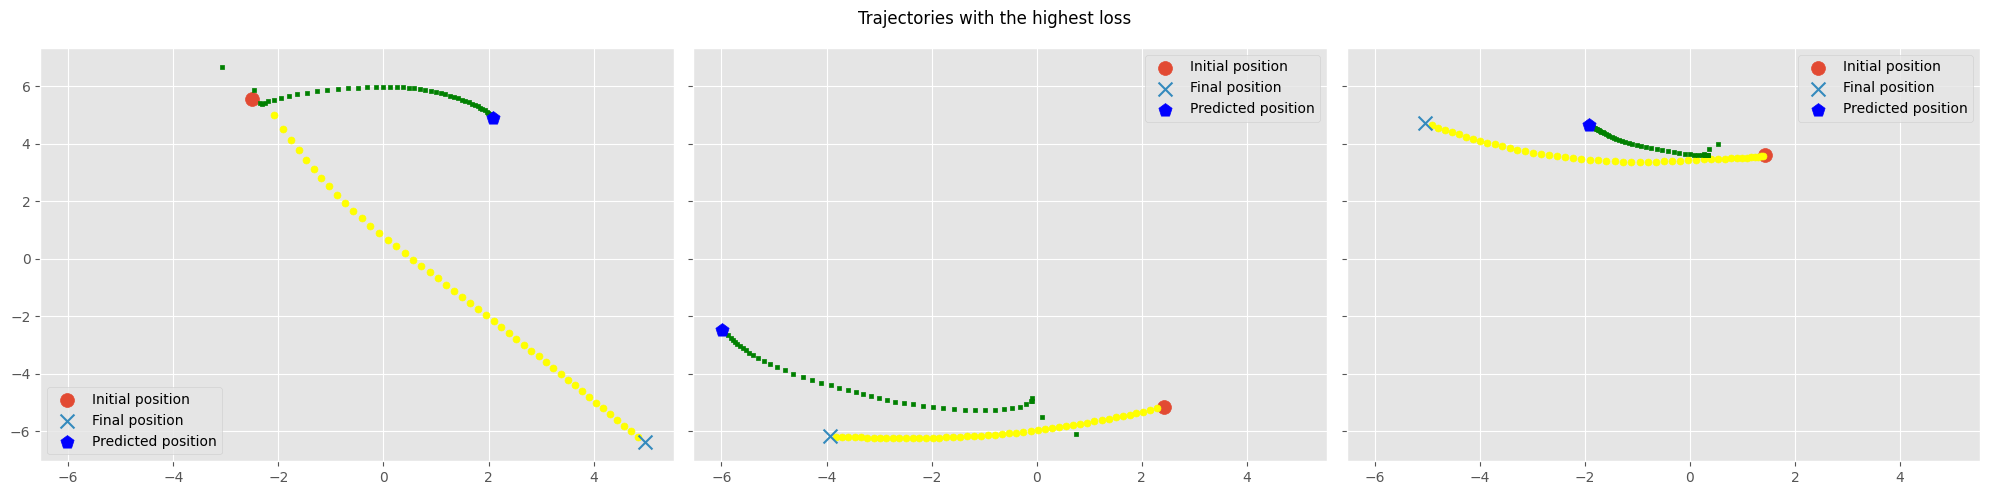

In [ ]:
plot_trajectories(highest_loss_indices[-1], title="Trajectories with the highest loss")

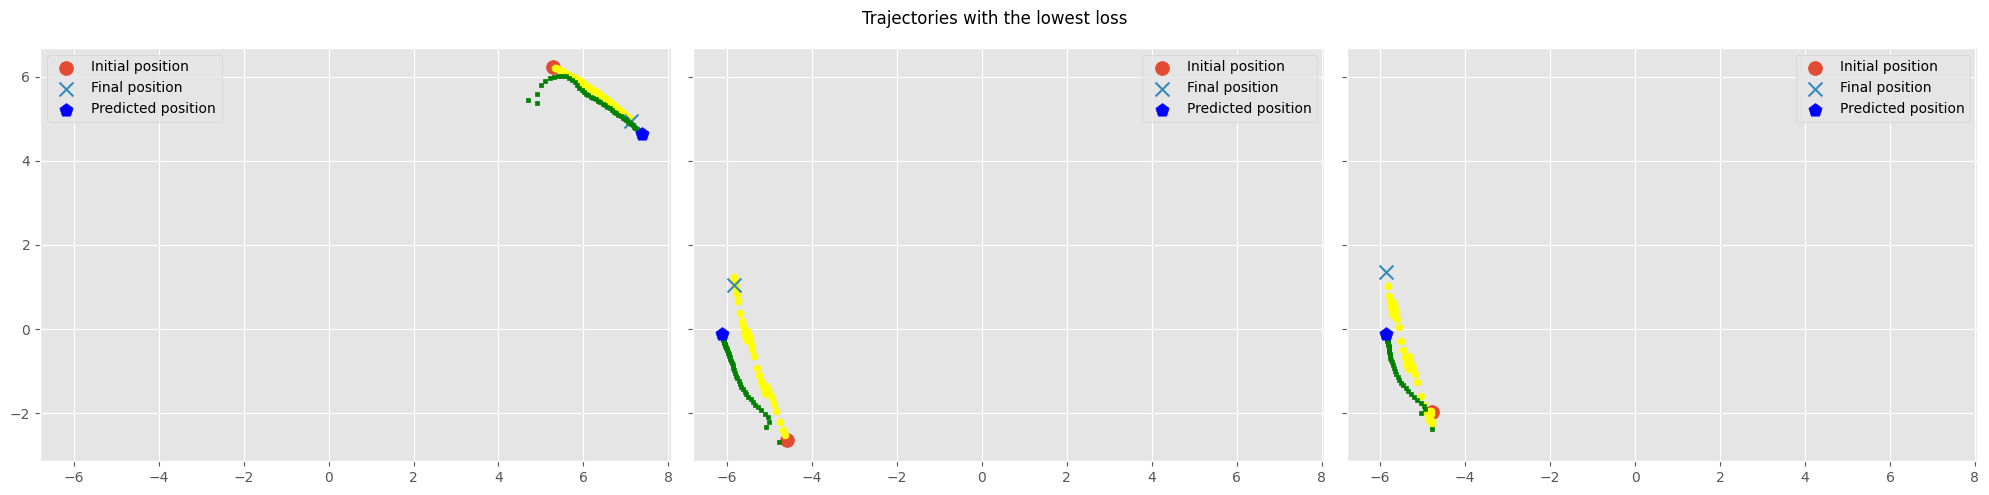

In [ ]:
plot_trajectories(lowest_loss_indices[0], title="Trajectories with the lowest loss")

ANOVA test for mass:
F_onewayResult(statistic=2.855746202026438, pvalue=0.10829264158002981)


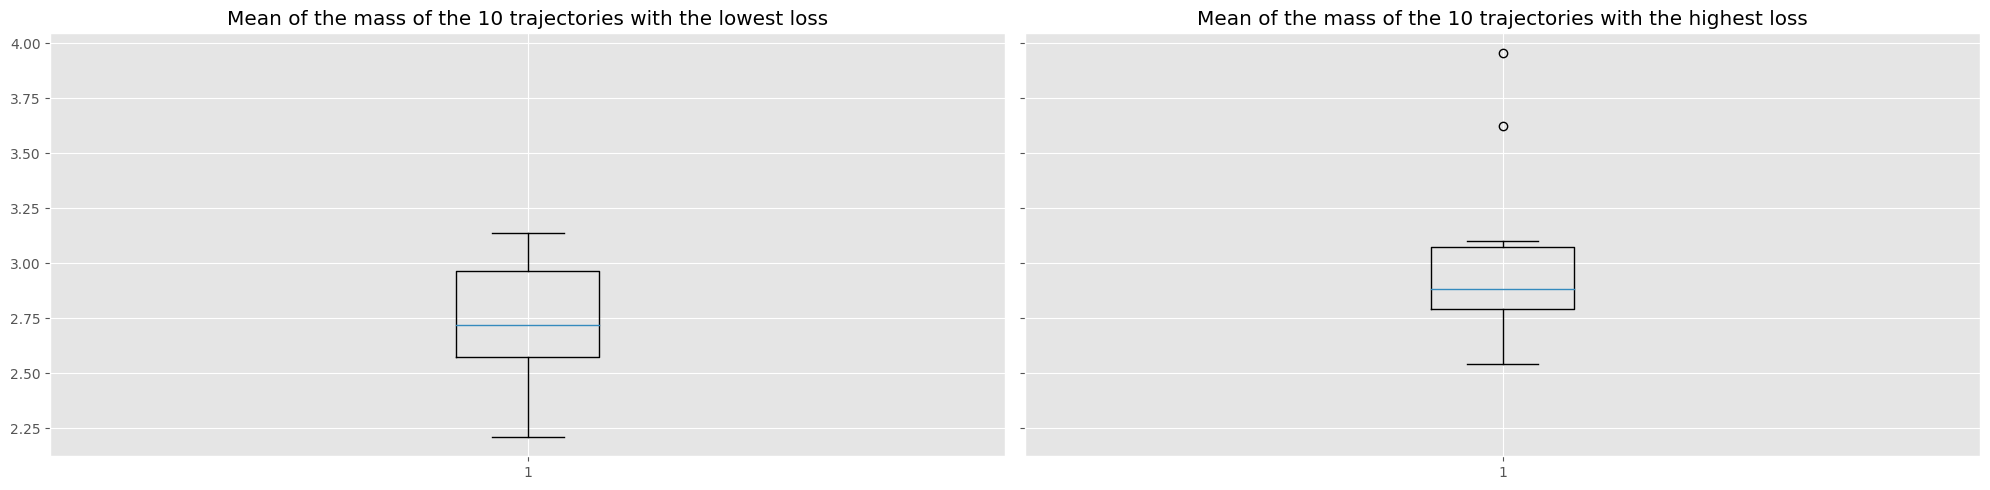

ANOVA test for vel_x:
F_onewayResult(statistic=0.7281325115309264, pvalue=0.4047017431251554)


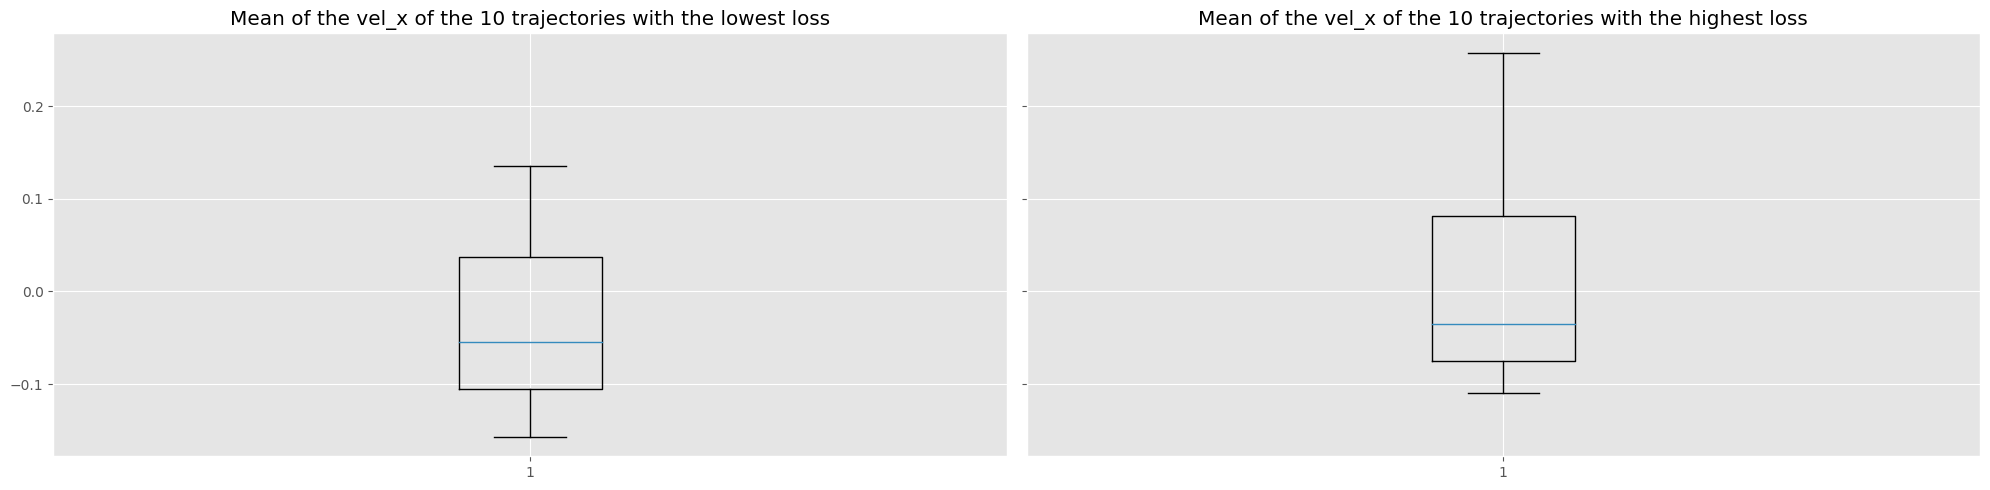

ANOVA test for vel_y:
F_onewayResult(statistic=3.918423479648017, pvalue=0.0632616107052052)


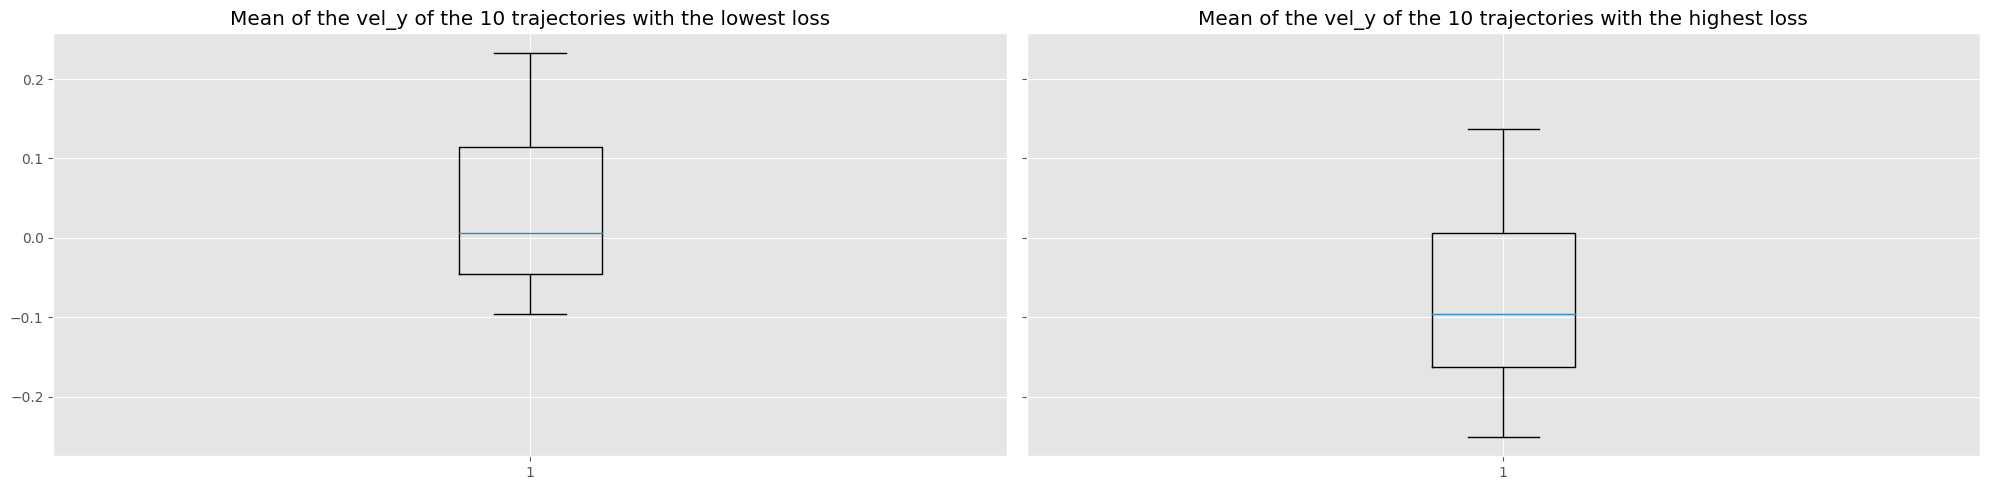

ANOVA test for pos_x:
F_onewayResult(statistic=0.01509573555920596, pvalue=0.9035756834760073)


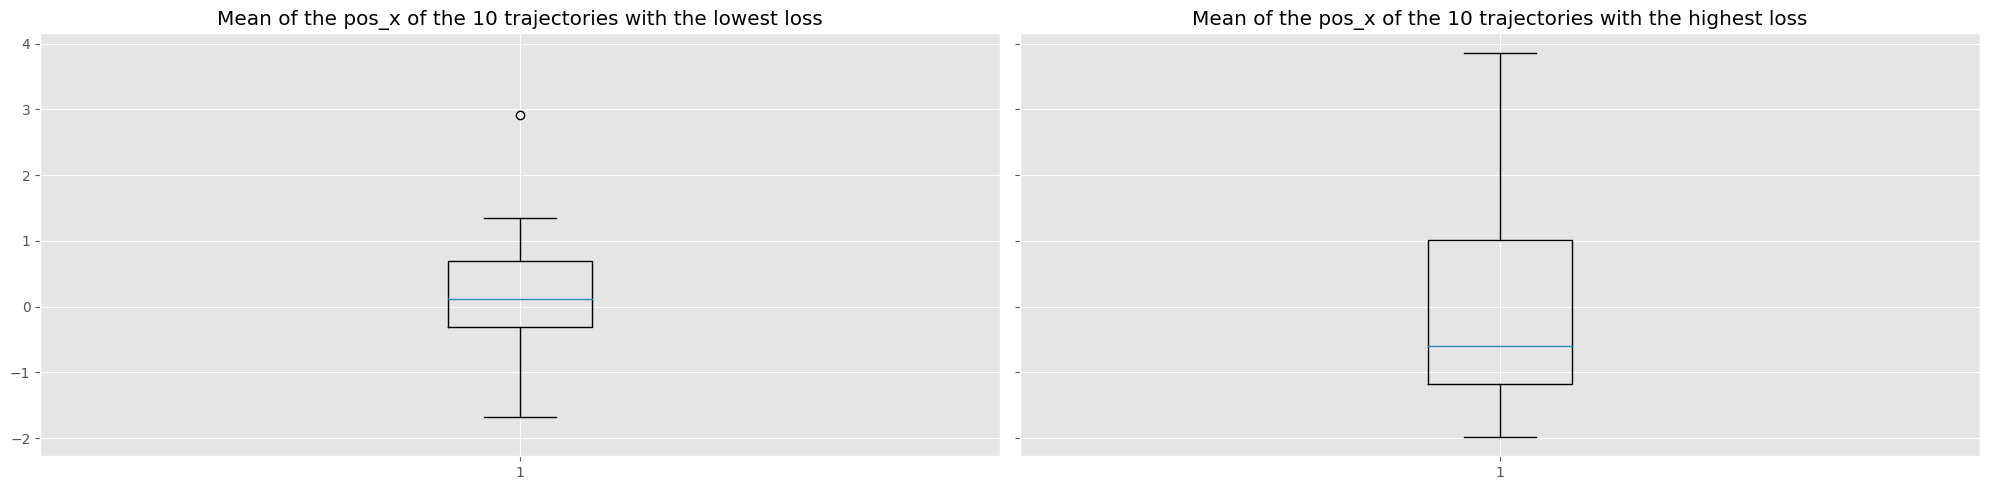

ANOVA test for pos_y:
F_onewayResult(statistic=0.024242007071690885, pvalue=0.8780035213620832)


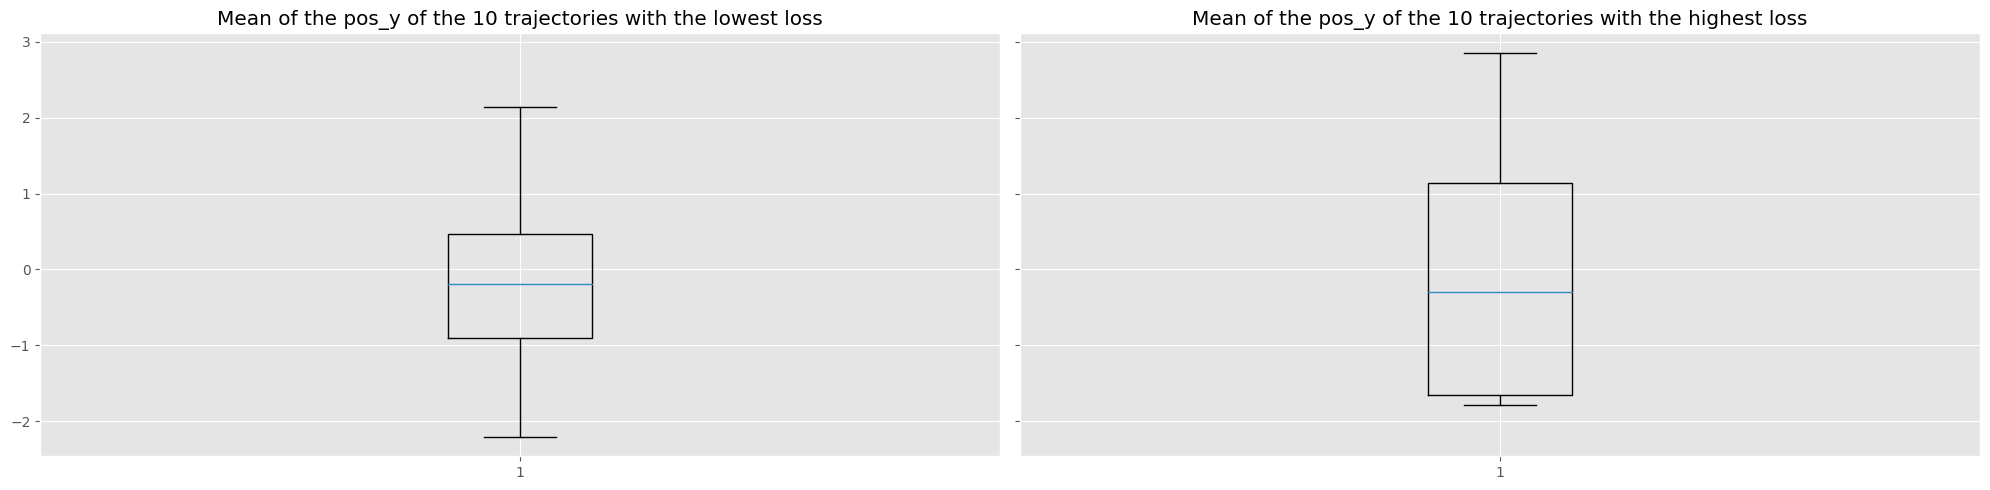

In [ ]:
plot_boxplot('mass')
plot_boxplot('vel_x')
plot_boxplot('vel_y')
plot_boxplot('pos_x')
plot_boxplot('pos_y')

# Task 3

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# use ggplot style
plt.style.use('ggplot')


def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

#### Create adjacency matrix

# Define distance metrics
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y)**2))

def inverse_distance(x, y):
    return 1 / euclidean_distance(x, y)

# Create adjacency matrix function
def create_adjacency_matrix(data, distance_metric):
    n = data.shape[0]
    adjacency_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:  # we don't calculate the distance of the object to itself
                # we extract the position [x, y] for both objects i and j
                position_i = data[i, 1:3]
                position_j = data[j, 1:3]
                adjacency_matrix[i, j] = distance_metric(position_i, position_j)
    return adjacency_matrix

# Validate input
def validate_input(X, adjacency_matrix):
    # X should be a 2D tensor
    assert X.dim() == 2, f"X must be 2D, but got shape {X.shape}"

    # The number of nodes should be the same in X and the adjacency matrix
    assert X.shape[0] == adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Mismatch in number of nodes: got {X.shape[0]} nodes in X, but {adjacency_matrix.shape[0]} nodes in adjacency matrix"

    # The adjacency matrix should be square
    assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Adjacency matrix must be square, but got shape {adjacency_matrix.shape}"

    print("All checks passed.")


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch_geometric.data import Data, DataLoader, Dataset

# DataLoaders for task 2
class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 2')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)   # y is now a 3D tensor

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t().contiguous().to(torch.long)

        data = Data(x=X, y=y, edge_index=edge_index)  # y is now a 3D tensor

        return data


filenames = [f'data/task 2_3/train/trajectory_{i}.npz' for i in range(900)]
split_point = int(len(filenames) * 0.8)
# Do training validation split
train_filenames = filenames[:split_point]
val_filenames = filenames[split_point:]

train_dataset = MyDataset(root='data/task 2_3/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=1)

val_dataset = MyDataset(root='data/task 2_3/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=1)

# Prepare for validation data set

test_filenames = [f'data/task 2_3/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 2_3/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=1)

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Encoder

import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class Encoder(nn.Module):
    def __init__(self, num_features, hidden_channels, latent_dim):
        super(Encoder, self).__init__()
        
        # Graph convolution layers
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels, batch_first=True)
        
        # Linear layers to compute mean and log variance of latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_dim)
        self.fc_var = nn.Linear(hidden_channels, latent_dim)
        
    def forward(self, data):
        # data has edge_index for graph structure
        # trajectory has shape (n, 49, 4), where n is the number of objects, 49 is timesteps, and 4 is (x, y, velocity_x, velocity_y)
        
        x, edge_index = data.y , data.edge_index

        # Graph convolution layers
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        
        # LSTM layer to encode temporal information
        # Assuming x now has shape (n, 49, hidden_channels) - one feature vector for each node at each timestep
        lstm_outputs, _ = self.lstm(x)
        final_output = lstm_outputs[:, -1, :]

        # Linear layers for mean and log variance
        mu = self.fc_mu(final_output)
        log_var = self.fc_var(final_output)

        return mu, log_var

# Example usage:
latent_dim = 16
encoder = Encoder(num_features=4, hidden_channels=64, latent_dim=latent_dim)

# Example usage:
latent_dim = 16
encoder = Encoder(num_features=4, hidden_channels=64, latent_dim=latent_dim)


In [ ]:
# Conditional prior

class MinGraphSAGE(torch.nn.Module):
    # FINAL MODEL!
    def __init__(self, num_features, hidden_channels, latent_dim):
        super(MinGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, latent_dim)

        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Droput
        x = self.dropout(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x

# Example usage:
latent_dim = 16
min_graph_sage = MinGraphSAGE(num_features=5, hidden_channels=64, latent_dim=latent_dim)


In [ ]:
# Decoder

class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(Decoder, self).__init__()
        # input_dim: dimension of the concatenated latent representation and conditioning vector
        # hidden_dim: number of hidden units in the LSTM
        # output_dim: dimension of the output at each timestep (4 in this case for x, y, vel_x, vel_y)
        # num_layers: number of layers in the LSTM
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_timesteps = 49

    def forward(self, x):
        # x: concatenated latent representation and conditioning vectors of shape [n, 32]
        
        # Repeat x along a new temporal dimension to create a sequence, with the repeated
        # x as the input at each time step. This is necessary because the LSTM expects
        # input of the form (batch_size, sequence_length, input_size).
        x = x.unsqueeze(1).repeat(1, self.num_timesteps, 1)
        
        # Pass the sequence through the LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out has shape [n, 49, hidden_dim]
        
        # Pass the LSTM output through a fully connected layer to get the final output
        output = self.fc(lstm_out)  # output has shape [n, 49, 4]
        
        return output

# Example usage:
decoder = Decoder(input_dim=32, hidden_dim=64, output_dim=4)


In [ ]:
# Test for a trial run
# Encode the trajectories 
# 16 dimensions for mu, logvar PER NODE
mu, logvar = encoder(graph)

# Encode the initial states (16 dimensions per node)
conditioning_vector = min_graph_sage(graph)

def reparameterize(mu, log_var):
    # Reparameterization trick to sample from a Gaussian
    # mu: mean matrix [n, 16]
    # log_var: log variance matrix [n, 16]
    std = torch.exp(0.5 * log_var)  # Standard deviation
    eps = torch.randn_like(std)  # 'random' noise
    return mu + eps * std

# Sampling from the latent space
z = reparameterize(mu, logvar)

# Concatenate the sampled latent representation with the conditioning vector
combined_features = torch.cat((z, conditioning_vector), dim=1)

reconstructed = decoder(combined_features)
original = graph.y


In [ ]:
# Final MODEL

class GraphCVAE(torch.nn.Module):
    def __init__(self, encoder, min_graph_sage, decoder):
        super(GraphCVAE, self).__init__()
        self.encoder = encoder
        self.min_graph_sage = min_graph_sage
        self.decoder = decoder

    def sample_latent(self, mu, log_var, use_prior=False):
        if use_prior:
            z = torch.randn_like(mu)
        else:
            std = torch.exp(0.5 * log_var)  
            eps = torch.randn_like(std)  
            z = mu + eps * std
        return z

    def forward(self, data, trajectory=None, is_inference=False):
        if is_inference:
            # In inference mode, encode only the initial state into conditioning vector
            conditioning_vector = self.min_graph_sage(data=data)
            z = torch.randn((data.num_nodes, 16)).to(conditioning_vector.device)
        else:
            # In training mode, encode both the initial state and the full trajectory
            mu, log_var = self.encoder(data=data)
            conditioning_vector = self.min_graph_sage(data=data)
            z = self.sample_latent(mu, log_var)

        # Concatenate the latent representation and conditioning vector
        combined_features = torch.cat((z, conditioning_vector), dim=1)
        
        # Pass the combined features to the decoder
        output_sequence = self.decoder(combined_features)

        return output_sequence


# Initialize components
encoder = Encoder(num_features=4, hidden_channels=16, latent_dim=16)
min_graph_sage = MinGraphSAGE(num_features=5, hidden_channels=16, latent_dim=16)
decoder = Decoder(input_dim=32, hidden_dim=64, output_dim=4)

# Initialize model
graph_cvae = GraphCVAE(encoder, min_graph_sage, decoder)
graph_cvae(graph, is_inference=True).shape

torch.Size([6, 49, 4])

In [ ]:
# Training 
# NOTE: Training only works on single graphs, not batches of graphs
# Due to this, training is very slow, and not necessarily converges
import torch
import torch.optim as optim

# Loss functions
def loss_function(recon_x, x, mu, log_var):
    MSE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD


# Training settings
epochs = 50
learning_rate = 0.01 

# Initialize components
encoder = Encoder(num_features=4, hidden_channels=16, latent_dim=16)
min_graph_sage = MinGraphSAGE(num_features=5, hidden_channels=16, latent_dim=16)
decoder = Decoder(input_dim=32, hidden_dim=64, output_dim=4)

# Initialize model
model = GraphCVAE(encoder, min_graph_sage, decoder)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    # Training
    for batch in train_dataloader:
        batch = batch[0]
        # Move data to the device (CPU or GPU)
        batch = batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch = model(data=batch, trajectory=batch.y)

        # Loss calculation
        mu, log_var = model.encoder(data=batch)
        loss = loss_function(recon_batch, batch.y, mu, log_var)

        # Backward pass
        loss.backward()

        # Optimization step
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch[0]
            # Move data to the device (CPU or GPU)
            batch = batch.to(device)

            # Forward pass
            recon_batch = model(data=batch, trajectory=batch.y)

            # Loss calculation
            mu, log_var = model.encoder(data=batch)
            loss = loss_function(recon_batch, batch.y, mu, log_var)

            val_loss += loss.item()

    # Logging
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_dataloader.dataset):.4f}, '
          f'Validation loss: {val_loss / len(val_dataloader.dataset):.4f}')


====> Epoch: 0 Average loss: 4834.6256, Validation loss: 3012.5416
====> Epoch: 1 Average loss: 4255.2876, Validation loss: 3696.2077
====> Epoch: 2 Average loss: 4267.2710, Validation loss: 3924.9832
====> Epoch: 3 Average loss: 4720.8010, Validation loss: 4587.9356
====> Epoch: 4 Average loss: 4931.4741, Validation loss: 4179.8552
====> Epoch: 5 Average loss: 4529.7283, Validation loss: 4508.9857
====> Epoch: 6 Average loss: 6181.6733, Validation loss: 4790.1939
====> Epoch: 7 Average loss: 5705.9921, Validation loss: 5001.0549
====> Epoch: 8 Average loss: 6337.1200, Validation loss: 5230.5267
====> Epoch: 9 Average loss: 5412.9052, Validation loss: 5728.8489
====> Epoch: 10 Average loss: 6081.0069, Validation loss: 4964.9698
====> Epoch: 11 Average loss: 7334.0022, Validation loss: 8674.6104
====> Epoch: 12 Average loss: 7993.9612, Validation loss: 5331.7389
====> Epoch: 13 Average loss: 5657.9289, Validation loss: 4193.4042
====> Epoch: 14 Average loss: 5098.0322, Validation loss: 